<a href="https://colab.research.google.com/github/TyreBeard/Deep-Dive-Data-Science-Projects/blob/main/BeardProject2HousePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of House Sales Price

## Problem Definition


- The Business Problem: figuring out what features impact the sale price of a home.
-The Data Science Problem: ( root mean squared percentage error - RMSPE ) Supervised, Classification regression
  - Targert _ Sales Price

## Data Collection/Sources


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


### File Paths

In [5]:
train_path = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.train.csv '
test_path = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.test.csv'
#base_path = '/content/Housing_Data.csv'
base_path = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv'

In [6]:
print(f'base_path: {base_path}')
print(f"train_path: {train_path}")
print(f"test_path: {test_path}")

base_path: https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.csv
train_path: https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.train.csv 
test_path: https://ddc-datascience.s3.amazonaws.com/Projects/Project.2-Housing/Data/Housing.Data.test.csv


## Load Data


In [7]:
train_orig = pd.read_csv(base_path)
train_orig.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000


## Quick view of meta data

In [8]:
train_orig.shape

(2637, 81)

We can see that our data successfully loaded. Now we can go on to the next step.

Let's get an overview of the data frame structure.

In [9]:
train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2637 non-null   int64  
 1   MS SubClass      2637 non-null   int64  
 2   MS Zoning        2637 non-null   object 
 3   Lot Frontage     2188 non-null   float64
 4   Lot Area         2637 non-null   int64  
 5   Street           2637 non-null   object 
 6   Alley            180 non-null    object 
 7   Lot Shape        2637 non-null   object 
 8   Land Contour     2637 non-null   object 
 9   Utilities        2637 non-null   object 
 10  Lot Config       2637 non-null   object 
 11  Land Slope       2637 non-null   object 
 12  Neighborhood     2637 non-null   object 
 13  Condition 1      2637 non-null   object 
 14  Condition 2      2637 non-null   object 
 15  Bldg Type        2637 non-null   object 
 16  House Style      2637 non-null   object 
 17  Overall Qual  

- Looks like we have a mix of data types and few columns with nulls.

- Let's group columns of similar data types together.

In [10]:
train_orig.dtypes.sort_values( ascending = False)

,0
Heating QC,object
Exterior 2nd,object
Exter Qual,object
Exter Cond,object
Foundation,object
...,...
Full Bath,int64
Half Bath,int64
Bedroom AbvGr,int64
Kitchen AbvGr,int64


In [11]:
train_orig.nunique().sort_values( ascending=False ) / train_orig.shape[0]

,0
PID,1.000000
Lot Area,0.682215
Gr Liv Area,0.461130
Bsmt Unf SF,0.409556
1st Flr SF,0.387562
...,...
Half Bath,0.001138
Utilities,0.001138
Alley,0.000758
Street,0.000758


- How many of each data type?

In [12]:
train_orig.dtypes.value_counts()

,count
object,43
int64,27
float64,11


- Looks like there might be 1 column that's a identifier columns, i.e. the number of unique items is the same as the number of rows, or unique count / number of rows == 1.

- Let's have a quick look at the target. Let's confirm that it is continous. And, does is have any nulls?

In [13]:
train_orig['SalePrice'].value_counts(dropna=False)

,count
SalePrice,
140000,31
135000,30
130000,28
155000,24
160000,22
...,...
138887,1
145100,1
256900,1


In [14]:
train_orig['SalePrice'].isnull().sum()

0

In [15]:
train_orig['SalePrice'].nunique()

983

In [16]:
train_orig['SalePrice'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2637 entries, 0 to 2636
Series name: SalePrice
Non-Null Count  Dtype
--------------  -----
2637 non-null   int64
dtypes: int64(1)
memory usage: 20.7 KB


- We can See there are no nulls in the target.
Lets run some summary stats

In [17]:
train_orig.describe( include = "all" ).transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PID,2637.0,NaN,NaN,NaN,714130147.70383,188752674.750322,526301100.0,528477010.0,535453040.0,907187010.0,1007100110.0
MS SubClass,2637.0,NaN,NaN,NaN,57.349261,42.499091,20.0,20.0,50.0,70.0,190.0
MS Zoning,2637,7,RL,2043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lot Frontage,2188.0,NaN,NaN,NaN,69.166819,23.356779,21.0,58.0,68.0,80.0,313.0
Lot Area,2637.0,NaN,NaN,NaN,10044.694729,6742.549521,1300.0,7436.0,9450.0,11526.0,164660.0
...,...,...,...,...,...,...,...,...,...,...,...
Mo Sold,2637.0,NaN,NaN,NaN,6.243838,2.722093,1.0,4.0,6.0,8.0,12.0
Yr Sold,2637.0,NaN,NaN,NaN,2007.795601,1.306403,2006.0,2007.0,2008.0,2009.0,2010.0
Sale Type,2637,10,WD,2286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sale Condition,2637,6,Normal,2166,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [18]:
train = train_orig.copy()
train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000


In [19]:
train.drop(columns=['Lot Frontage', 'Garage Yr Blt'], inplace=True)

In [20]:
#train.drop(columns=['SalePrice'], inplace=True)

## Exploratory Data Analysis


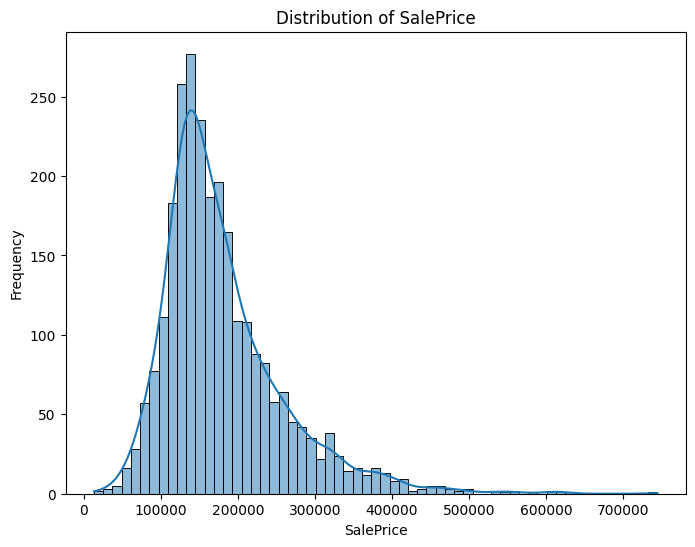

In [21]:
# prompt: display hist of SalePrice

plt.figure(figsize=(8, 6))
sns.histplot(train['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()


We can see that the target is normal distributed

In [22]:


# Convert columns to numeric, coercing errors to NaN
for col in train.columns:
    try:
        train[col] = pd.to_numeric(train[col], errors='coerce')
    except:
        pass

# Display correlation matrix
corr_matrix = train.corr()
corr_matrix


,PID,MS SubClass,MS Zoning,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
PID,1.000000,0.003801,NaN,0.023266,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.002713,NaN,NaN,NaN,-0.016698,-0.051828,0.016902,NaN,NaN,-0.258332
MS SubClass,0.003801,1.000000,NaN,-0.220406,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.005281,NaN,NaN,NaN,-0.016237,-0.006331,-0.015536,NaN,NaN,-0.078857
MS Zoning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lot Area,0.023266,-0.220406,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.101980,NaN,NaN,NaN,0.053556,0.015153,-0.027787,NaN,NaN,0.268516
Street,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mo Sold,-0.051828,-0.006331,NaN,0.015153,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.037580,NaN,NaN,NaN,0.000197,1.000000,-0.160078,NaN,NaN,0.052800
Yr Sold,0.016902,-0.015536,NaN,-0.027787,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.049366,NaN,NaN,NaN,0.027787,-0.160078,1.000000,NaN,NaN,-0.030053
Sale Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sale Condition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- We can see Sales Price is independent from the featers

In [23]:

plt.figure(figsize=(100, 100))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


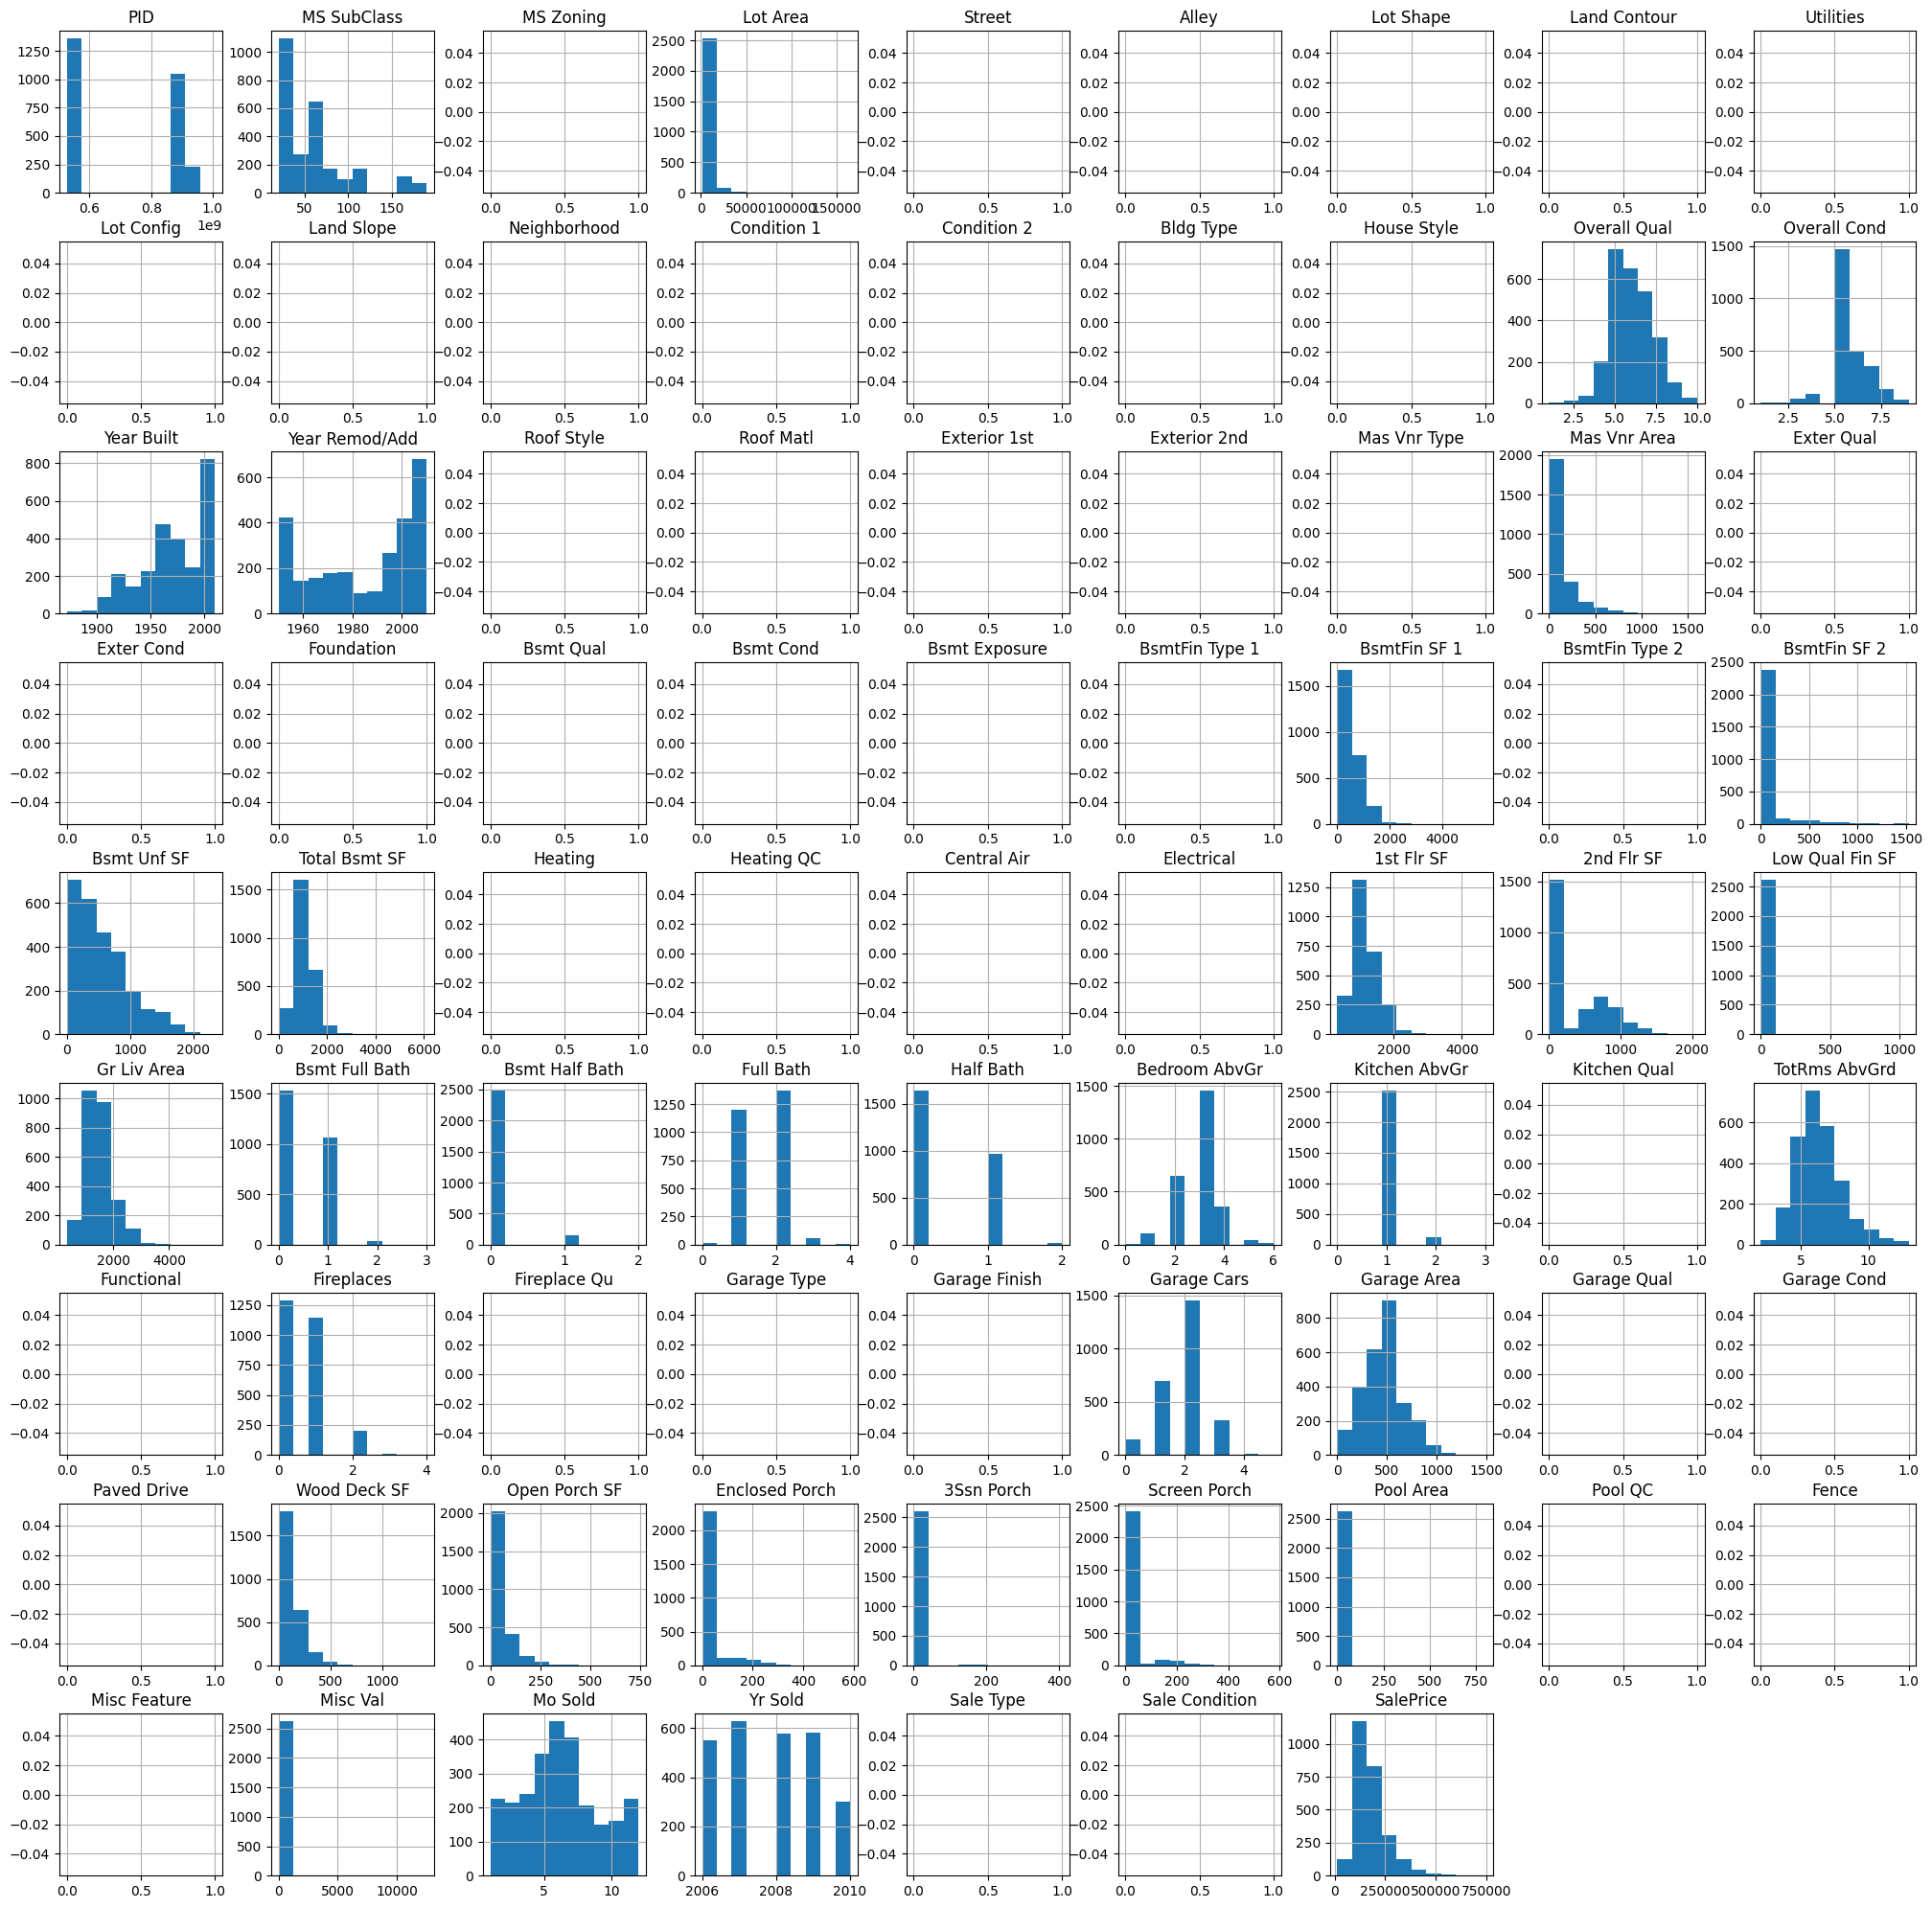

In [28]:
train.hist(figsize=(25, 25))
plt.show()

- You can tell the difference between catagorical and discreet


## Processing


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load your raw CSV file
df = pd.read_csv('/content/Housing_Data.csv')  # Replace with your file name

# 1. Basic data cleaning
def prepare_data(df):
    # Make a copy to avoid modifying original data
    df_clean = df.copy()

    # Convert column names to lowercase and replace spaces with underscores
    df_clean.columns = df_clean.columns.str.lower().str.replace(' ', '_')

    # Remove any completely empty columns
    df_clean = df_clean.dropna(axis=1, how='all')

    # Handle missing values
    numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
    # Fill numeric missing values with median
    df_clean[numeric_columns] = df_clean[numeric_columns].fillna(df_clean[numeric_columns].median())

    # Fill non-numeric missing values with mode (most frequent value)
    non_numeric_columns = df_clean.select_dtypes(exclude=[np.number]).columns
    df_clean[non_numeric_columns] = df_clean[non_numeric_columns].fillna(df_clean[non_numeric_columns].mode().iloc[0])

    return df_clean

# 2. Split into features and target
def split_and_save(df_clean, target_column, output_path='./'):
    # Separate features and target
    features = df_clean.drop(columns=[Sale_price])
    target = df_clean[Sale_price]

    # Save to separate CSV files
    features.to_csv(f'{output_path}features.csv', index=False)
    target.to_csv(f'{output_path}target.csv', index=False)

    return features, target

# Function to calculate RMSPE
def calculate_rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100

# Clean the data
df_clean = prepare_data(df)

# Check data types before splitting
print("\nData Types:")
print(df_clean.dtypes)

# Check for any remaining missing values
print("\nMissing Values:")
print(df_clean.isnull().sum())

# Method 1: Select features using column names
features = ['sale_condition', 'yr_sold', 'pool_area', 'garage_cond', 'roof_matl']
target = 'saleprice'

# Convert to the format sklearn expects
X = df_clean[features]  # Features (multiple columns)
y = df_clean[target]    # Target (single column)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    'Ridge': Ridge(alpha=1.0,),
    'Lasso': Lasso(alpha=1.0, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5,max_iter=10000 )
}

# Create results dictionary
results = {}

# Define preprocessing steps
categorical_features = ['sale_condition', 'garage_cond', 'roof_matl']
numeric_features = ['yr_sold', 'pool_area']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Update pipeline to include preprocessing
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Calculate metrics
    results[name] = {
        'train_rmspe': calculate_rmspe(y_train, y_pred_train),
        'test_rmspe': calculate_rmspe(y_test, y_pred_test),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test)
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Data Types:
pid                 int64
ms_subclass         int64
ms_zoning          object
lot_frontage      float64
lot_area            int64
                   ...   
mo_sold             int64
yr_sold             int64
sale_type          object
sale_condition     object
saleprice           int64
Length: 81, dtype: object

Missing Values:
pid               0
ms_subclass       0
ms_zoning         0
lot_frontage      0
lot_area          0
                 ..
mo_sold           0
yr_sold           0
sale_type         0
sale_condition    0
saleprice         0
Length: 81, dtype: int64

Ridge Results:
train_rmspe: 46.7486
test_rmspe: 44.9838
train_r2: 0.1817
test_r2: 0.1530

Lasso Results:
train_rmspe: 46.6002
test_rmspe: 45.0338
train_r2: 0.1827
test_r2: 0.1530

ElasticNet Results:
train_rmspe: 63.7475
test_rmspe: 50.8162
train_r2: 0.0439
test_r2: 0.0506


## Data Visualization/Communication of Results


In [33]:

results_df = pd.DataFrame(results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})

results_df


,Model,train_rmspe,test_rmspe,train_r2,test_r2
0,Ridge,46.748574,44.983848,0.181673,0.153045
1,Lasso,46.600173,45.033827,0.182740,0.153027
2,ElasticNet,63.747491,50.816180,0.043919,0.050552


## Conclusion

- From the three methods used the ElasticNet approach was the most efficent with a 50% test score compared to 63% from train data

## Improvements
- Using different features
- Use mean to encode catagorical data